In [2]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from skimage import feature

Useful functions:

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename, dim = '2d'):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    if dim == '2d':
        X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    else:
        X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])

    return X

def value_to_class(v):
    df = np.mean(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

Get training data and labels:

In [4]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)] 

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]


Loading 100 images
Loading 100 images


In [5]:
N_IMAGES_TRAIN = len(files)

Extract patches:

In [6]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

Build training and testing data matrices:

In [7]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
X_train = X[0:len(X)//2]
X_test = X[len(X)//2:len(X)]

Y = np.asarray([value_to_class(gt_patches[i]) for i in range(len(gt_patches))])
Y_train = Y[0:len(X)//2]
Y_test = Y[len(Y)//2:len(Y)]

# Features extraction

Canny method:

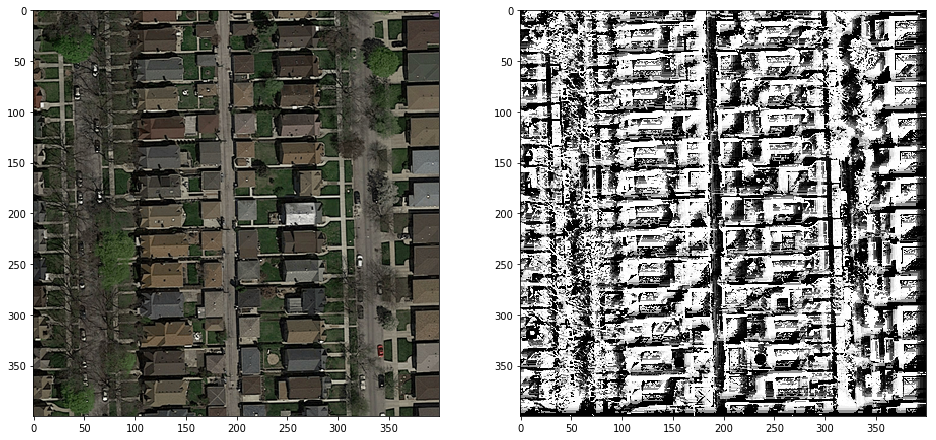

In [96]:
plt.figure(figsize=(16,16))
fc=feature.local_binary_pattern(imgs[0][:,:,0],20,10)

plt.subplot(1,2,1)
plt.imshow(imgs[0]);
plt.subplot(1,2,2)
plt.imshow(fc, cmap='Greys_r');

Histogram of oriented gradients:

[0.13005162 0.09430479 0.04808659 0.08965882 0.19662022 0.19926173
 0.0823871  0.06506613 0.03377041 0.06071309]


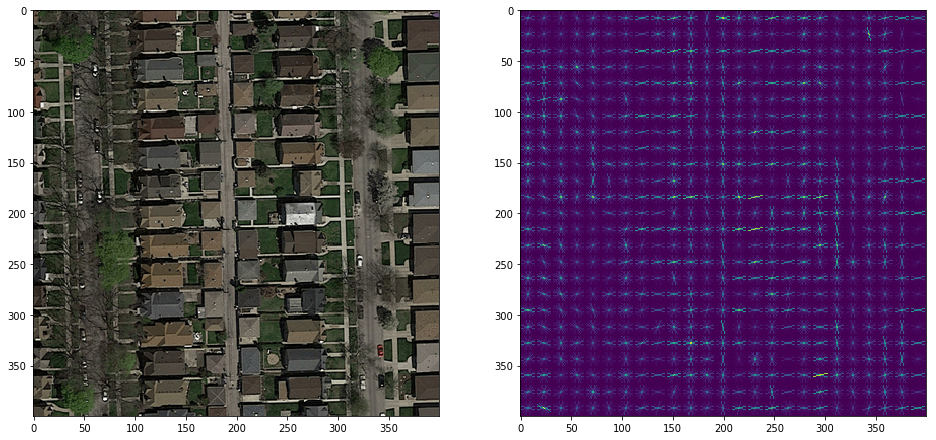

<Figure size 432x288 with 0 Axes>

In [95]:
plt.figure(figsize=(16,8))
v,mr=feature.hog(imgs[0][:,:,0], orientations = 10, pixels_per_cell=(16,16), cells_per_block=(1,1), visualize=True, feature_vector=True)
#v,mg=feature.hog(imgs[0][:,:,1], orientations = 10, pixels_per_cell=(8,8), visualize=True)
#v,mb=feature.hog(imgs[0][:,:,2], orientations = 10, pixels_per_cell=(8,8), visualize=True)
plt.subplot(1,2,1)
plt.imshow(imgs[0]);
plt.subplot(1,2,2)
plt.imshow(mr);
# plt.subplot(2,2,3)
# plt.imshow(mg);
# plt.subplot(2,2,4)
# plt.imshow(mb);
# plt.imshow(mb);
plt.figure()
print(v[0:10])

# Logistic Regression 

In [7]:
from sklearn import linear_model

# we create an instance of the classifier and fit the data
classif = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
classif.fit(X_train, Y_train)

/Users/virginiabordignon/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [8]:
# Predict on the training set
Z = classif.predict(X_train)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_train)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))

True positive rate = 0.7043682712535577
Positive predicted value = 0.35473015081640286
F1 score = 0.47183653168649226


In [9]:
# Predict on the training set
Z = classif.predict(X_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_test)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))

True positive rate = 0.7151664611590629
Positive predicted value = 0.3351051536861567
F1 score = 0.4563695019277677


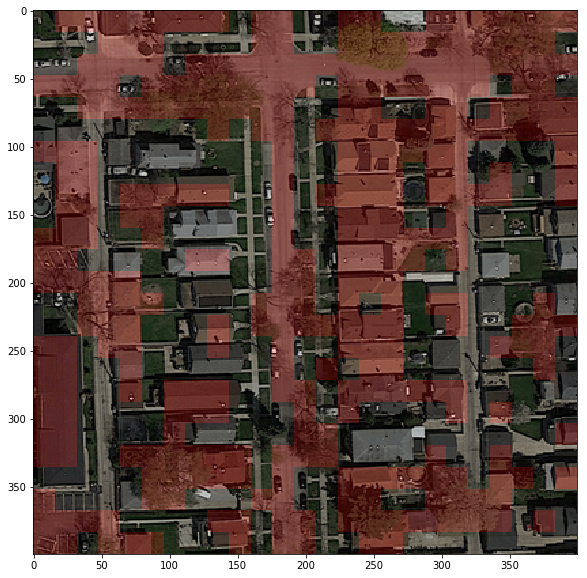

In [10]:
img_idx = 50
Xi = extract_img_features(image_dir + files[img_idx], '3d')
Zi = classif.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)



# Random Forest Classifier 

In [11]:
from sklearn import ensemble

classif = ensemble.RandomForestClassifier(100)
classif.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
# Predict on the training set
Z = classif.predict(X_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_test)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))


True positive rate = 0.3875462392108508
Positive predicted value = 0.6036105242942194
F1 score = 0.4720282345873695


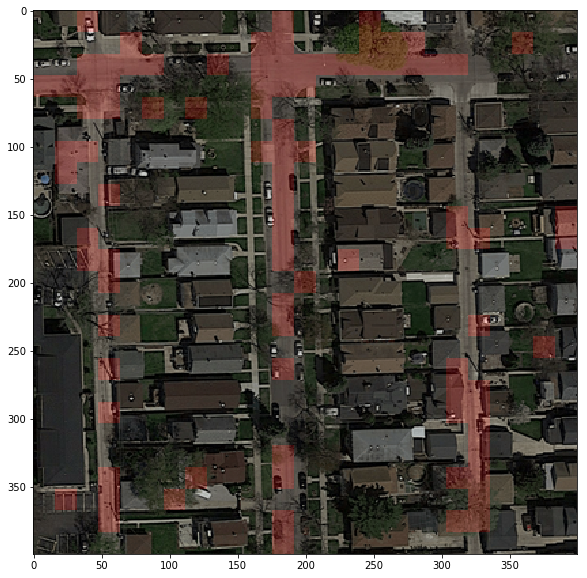

In [13]:
img_idx = 50
Xi = extract_img_features(image_dir + files[img_idx], '3d')
Zi = classif.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)



Generate Submission

In [14]:
N_TEST_IMAGES = 50

In [15]:
# Loaded a set of images
root_test_dir = "test_set_images/"
test_dir = ['test_'+str(i)+'/' for i in range(1,N_TEST_IMAGES+1)]
test_images = ['test_'+str(i)+'.png' for i in range(1,N_TEST_IMAGES+1)]


In [16]:
submission_filename = 'prediction.csv'

# with open(submission_filename, 'w') as f:
#     f.write('id,prediction\n')
#     for i in range(N_TEST_IMAGES):
#         Xi = extract_img_features(root_test_dir + test_dir[i]+test_images[i], '3d')
#         Zi = classif.predict(Xi)
    
#         strings=[]
#         count = 0
#         for j in range(0, 608, patch_size):
#             for k in range(0, 608, patch_size):
#                 strings.append("{:03d}_{}_{},{}".format(i+1, j, k, Zi[count]))
#                 count = count + 1


#         f.writelines('{}\n'.format(s) for s in strings)
        

See one test image vs classification:

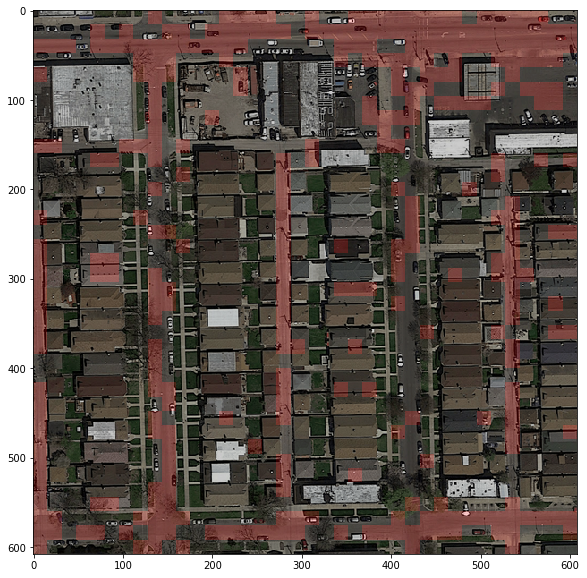

In [17]:
Xi = extract_img_features(root_test_dir + test_dir[0]+test_images[0], '3d')
Zi = classif.predict(Xi)
predicted_im = label_to_img(608, 608, patch_size, patch_size, Zi)
im = load_image(root_test_dir + test_dir[0]+test_images[0])
new_img = make_img_overlay(im, predicted_im)

predicted_im.shape
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(new_img)